# imports

In [ ]:
import os
path = os.getcwd()

if path[1:5] == 'Home':
    %run /Home/siv30/wad005/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Home/siv30/wad005/master/GRB/src/dau_det_distribution.ipynb
    %run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb

else:
    %run /Users/andreas/phys/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Users/andreas/phys/master/GRB/src/dau_det_distribution.ipynb
    %run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Users/andreas/phys/master/GRB//xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Users/andreas/phys/master/GRB//xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb
    
from stingray import Lightcurve as LC
from stingray import CrossCorrelation as CC
import numpy as np
import matplotlib.pyplot as plt
import os, re, sys
from astropy.io import fits, ascii
from astropy.time import Time

from gbm.data import TTE,RSP,Trigdat
from gbm.binning.unbinned import bin_by_time
from gbm.plot import Lightcurve, Spectrum
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial #working in ctime for example
%matplotlib inline

#%run /Home/siv30/wad005/useful_py_functions/matplotlib_custom_style_and_macros.py

# Notes
    XSPEC
    -HED is best fit with a cutplep model!
    -KW/FERMI is best fit with Band model. const factor ~1.2 for FERMI
    -KW/FERMI/HED tried fitting with Band model. Got const factor 2.6 for HED and 1.2 for FERMI
    
    

In [2]:
binsize = 0.002 #s

# KW

In [118]:
#importing KW LC

kw_fn = 'GRB181222B_2ms.txt'
kw_df = pd.read_csv(kw_lc_path+kw_fn,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float32), kw_df["Tf"].to_numpy(dtype=np.float32),kw_df["G1"].to_numpy(dtype=np.float32), kw_df["G2"].to_numpy(dtype=np.float32), kw_df["G3"].to_numpy(dtype=np.float32)
kw_df.head()

,Ti,Tf,G1,G2,G3
0,-0.512,-0.510,0.00,1.00,0.0
1,-0.510,-0.508,5.04,1.00,0.0
2,-0.508,-0.506,1.00,0.00,0.0
3,-0.506,-0.504,0.00,0.00,1.0
4,-0.504,-0.502,1.00,2.01,0.0


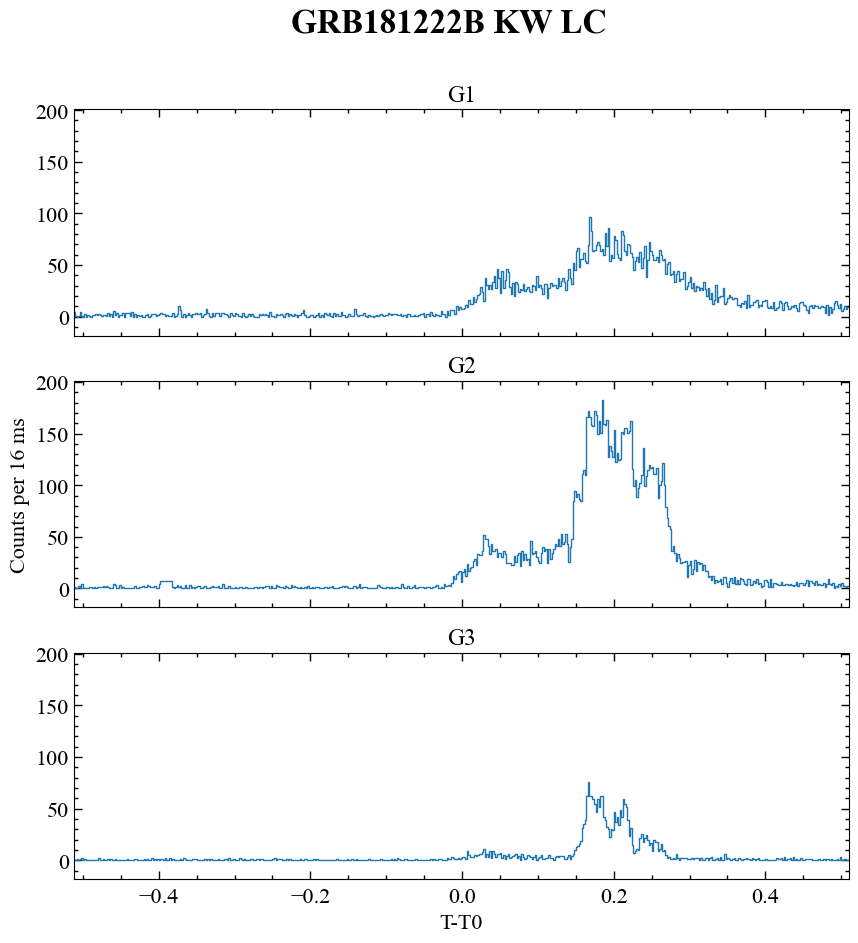

In [119]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharey=True, sharex=True)

kw_dt = np.round(np.diff(kw_bin_lo),3)
jx_kw = np.where(kw_dt>0.002)[0][0] #finding first entry where the binsize increases

# Plot the data for 'G1' in the first subplot
axs[0].step(x=kw_bin_lo[:jx_kw],y=G1[:jx_kw],where='pre')
axs[0].set_title('G1')

# Plot the data for 'G2' in the second subplot
axs[1].step(x=kw_bin_lo[:jx_kw],y=G2[:jx_kw],where='pre')
axs[1].set_title('G2')
axs[1].set_ylabel('Counts per 16 ms')

# Plot the data for 'G3' in the third subplot
axs[2].step(x=kw_bin_lo[:jx_kw],y=G3[:jx_kw],where='pre')
axs[2].set_title('G3')

plt.xlabel('T-T0')
plt.suptitle('GRB181222B KW LC', fontsize=24, fontweight='bold')
plt.show()

In [120]:
kw_dt = np.round(np.diff(kw_bin_lo[:jx_kw]),3)
np.all(kw_dt==0.002)

True

In [121]:
bins = np.append(kw_bin_lo[:jx_kw],kw_bin_lo[jx_kw]) #from -0.512 to 0.512
G1,G2,G3 = G1[:jx_kw],G2[:jx_kw],G3[:jx_kw]

# ASIM
    
    
    GENERAL LOADING OF DATA
    ------------------------------------------------------
    -ref. time: 2018-12-22 20:11:36.576
    
    
    
    
    sp1_5 INTERVAL T0+0.0s --> T0+0.512 
    ------------------------------------------------------
    -HED Safety time:  0.509 % removed
    -ASIM starts at ~T0-0.540s and ends at ~T0+1.4s (unshifted)
    -Using bakcground found in this trigger file
    
    
    LARGER INTERVAL
    ------------------------------------------------------
    
    
    
    
    CC
    ------------------------------------------------------
    
    -eye balling:          -0.43 s
    -eye balling + KW CC:  -0.44 s
    -ToF:                        s
    -ASIM + FERMI CC:     -0.438 s (F ref. frame)
    
    
    >> tlagg_asim = -0.440 s seems to be nearly perfect CC
    
    
    
    
    Background
    ------------------------------------------------------
    - applying background found in the trigger file for HED
    
    
    
    
    xspec
    ------------------------------------------------------
    HED is best fit with a cutplep model!
    
    

In [122]:
df_asim = harvest_data(fn='2018_12_22_20_11_36',T0='2018-12-22T20:11:36.576')
T0_asim = datetime.fromisoformat('2018-12-22T20:11:36.576')
df_asim.head()

dau/det starting from index 1
tus array given in seconds
safety time:  0.509 % removed
sorted by tus (s)


,year,month,day,hour,minute,second,erg,dau,det,datetime,tus,adr,keV,st,dt,flag
0,2018,12,22,20,8,40.938759,85,1,1,2018-12-22 20:08:40.938758722,-175.637241,1,825.9152,2.303661,0.000,False
1,2018,12,22,20,8,40.93884,78,1,1,2018-12-22 20:08:40.938839972,-175.637160,1,759.8686,2.039474,81.250,False
2,2018,12,22,20,8,40.938841,57,3,3,2018-12-22 20:08:40.938840639,-175.637159,9,1258.9750,1.172650,552.445,False
3,2018,12,22,20,8,40.939426,91,4,3,2018-12-22 20:08:40.939426472,-175.636574,12,1098.5125,2.328375,0.000,False
4,2018,12,22,20,8,40.939427,28,1,2,2018-12-22 20:08:40.939426528,-175.636573,2,518.8322,1.037664,586.528,False


In [19]:
#ready to CC with KW!

In [123]:
tus_asim = df_asim['tus'].to_numpy()
ix_asim = np.searchsorted(tus_asim,-2)
tus_asim_burst = tus_asim[ix_asim:]
df_asim_burst = df_asim.truncate(before=ix_asim)

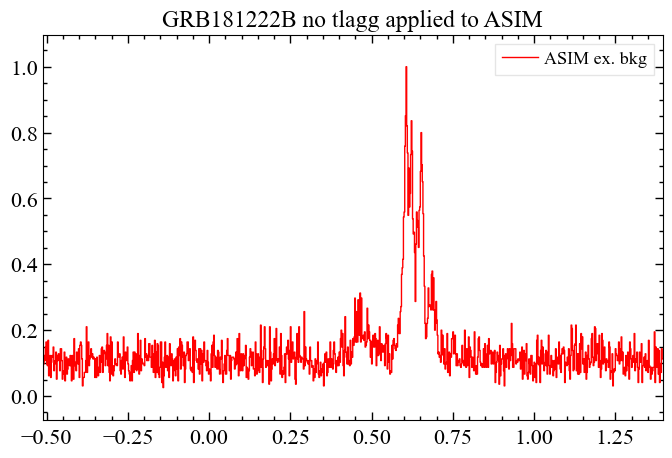

In [124]:
tus_asim = df_asim_burst['tus'].to_numpy()
bins_asim = np.arange(-0.512,1.4,binsize)
asim_counts, asim_edges = np.histogram(tus_asim_burst, bins=bins_asim)
plt.step(x=asim_edges[:-1], y=asim_counts/max(asim_counts), where='pre', label='ASIM ex. bkg',c='r')
plt.legend()
plt.title("GRB181222B no tlagg applied to ASIM")
plt.show() #evident that the asim lc must be shifted by ~ -0.4s

# FERMI
    -tlagg_fermi for n2 seems to be ~ -0.004 s


In [125]:
GRB_id = "GRB181222B"
bn='bn181222841' # GRB id for Fermi
data_dir = path_FERMI_dir + "/" + bn +"/" #setting path to data dir
unit='all' #which units to use. which filenames to open

fn_trigdat = data_dir+'glg_trigdat_'+unit+'_'+bn+'_v01.fit' #check of its a different v01.fit

trigdat = Trigdat.open(fn_trigdat)
print(trigdat)
print(trigdat.trigtime)


# Once extracted, it has the full capabilities of the [```Ctime```](./PhaiiData.ipynb) class.  You can also retrieve the sum of the detectors:
# the triggered detectors
trig_dets = trigdat.triggered_detectors
print(trig_dets)

grb_ra, grb_dec = 311.7605, 24.5163  #put in manually

all_dets=np.array(['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb','b0','b1'])
point_dets = np.zeros(shape=(all_dets.size,2))
for i in range(all_dets.size):
    point_dets[i,:] = trigdat.detector_pointing(all_dets[i], trigdat.trigtime)

#Q: Finding out where each detector is pointing and storing in a 14x2 matrix?
# ra, dec?

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Print dets with increasing angular separation from the GRB position
idx_sort_angsep = np.argsort(ang_sep) #sorting in increasing order
for i in idx_sort_angsep:
    print(all_dets[i],round(ang_sep[i],3))
    
#print(all_dets[idx_sort_angsep]) #sorting
#print(ang_sep[idx_sort_angsep]) #sorting


#The detectors nearest to the burst are listed first. If the degree is more than 60 deg, be careful to use the response function


glg_trigdat_all_bn181222841_v01.fit
567202302.438436
['n2', 'n3', 'n4', 'n6', 'n7']
n4 26.787
n3 28.14
n7 57.267
n8 58.272
n6 59.46
b0 70.459
n5 73.398
n0 75.631
n1 88.522
nb 106.295
n9 108.19
b1 109.541
n2 123.419
na 153.593


In [126]:
print(f'lat {np.round(trigdat.get_latitude(trigdat.trigtime),4)}')
print(f'lon: {np.round(trigdat.get_longitude(trigdat.trigtime),4)}')
print(f'alt: {np.round(trigdat.get_altitude(trigdat.trigtime)/1e3,4)} km')

lat 3.9844
lon: 332.0369
alt: 523.2239 km


In [127]:
print(trigdat.trigtime)
T0_fermi = datetime.fromisoformat('2018-12-22T20:11:37.438')
print(T0_fermi)

567202302.438436
2018-12-22 20:11:37.438000


In [129]:
unit = all_dets[idx_sort_angsep][5] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[1] #unit of the first trigger detector. What unit is this?
print(unit)

fn_tte = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'
fn_rsp = data_dir+'glg_cspec_'+unit+'_'+bn+'_v01.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels

b0


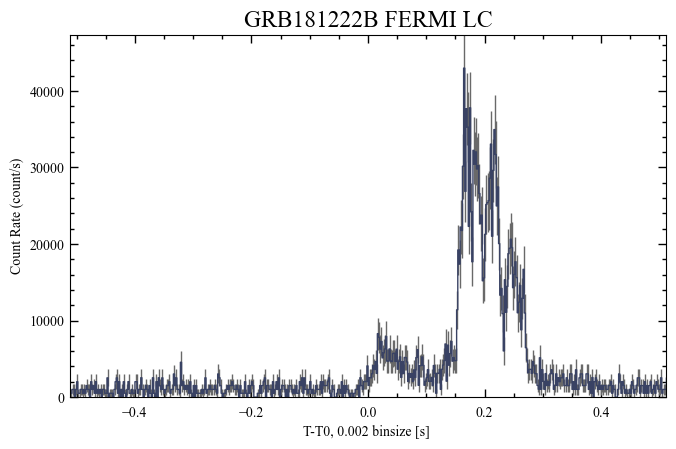

In [131]:
# open a TTE file
tte = TTE.open(fn_tte)

#bin_by_time is defined in imports. now have the spectra for each bin 
phaii = tte.to_phaii(bin_by_time,binsize,time_ref=0.0) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

erange = (350,2e4)
lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (bins[0],bins[-1])
lcplot.ax.set_title(f'GRB181222B FERMI LC')
lcplot.ax.set_xlabel(f'T-T0, {binsize} binsize [s] ')
#plt.savefig(fname='/Users/andreas/phys/master/GRB/pyplots/GRB211211A_FERMI_LC.png')
plt.show()

# CC

## KW / FERMI cc

In [132]:
# applying the ToF
KW_T0 = datetime.fromisoformat('2018-12-22T20:11:34.563')
tof_kw_asim = 2.8716 # reached ISS first
tof_asim_fermi = 0.0026 #reaced ISS first
fermi_shift_T0 = KW_T0 + timedelta(seconds=tof_kw_asim+tof_asim_fermi)
print(fermi_shift_T0)
fermi_T0 = datetime.fromisoformat('2018-12-22T20:11:37.438')
print(fermi_T0)
tlagg_fermi = (fermi_T0-fermi_shift_T0).total_seconds()
print(f'fermi_tlagg estimation: {tlagg_fermi} s. apply to tus_fermi')

2018-12-22 20:11:37.437200
2018-12-22 20:11:37.438000
fermi_tlagg estimation: 0.0008 s. apply to tus_fermi


In [133]:
# fermi bkg estimation
tus_fermi = tte.data.time

i_bkg,j_bkg = find_nearest(tus_fermi,-80),find_nearest(tus_fermi,-20)
tus_fermi_bkg = tus_fermi[i_bkg:j_bkg]

fermi_bkg_c,fermi_bkg_e = np.histogram(tus_fermi_bkg,bins=np.arange(min(tus_fermi_bkg),max(tus_fermi_bkg)+binsize,binsize))
fermi_mean_bkg = np.round(np.mean(fermi_bkg_c),4)
print(fermi_mean_bkg)

2.943


In [134]:
#fermi
tus_fermi = tte.data.time
fermi_ix,fermi_jx = np.searchsorted(tus_fermi,bins[0]), np.searchsorted(tus_fermi,bins[-1])
tus_fermi = tus_fermi[fermi_ix:fermi_jx]
fermi_counts,fermi_edges = np.histogram(tus_fermi,bins=bins)
fermi_counts = np.maximum(fermi_counts - fermi_mean_bkg, 0)

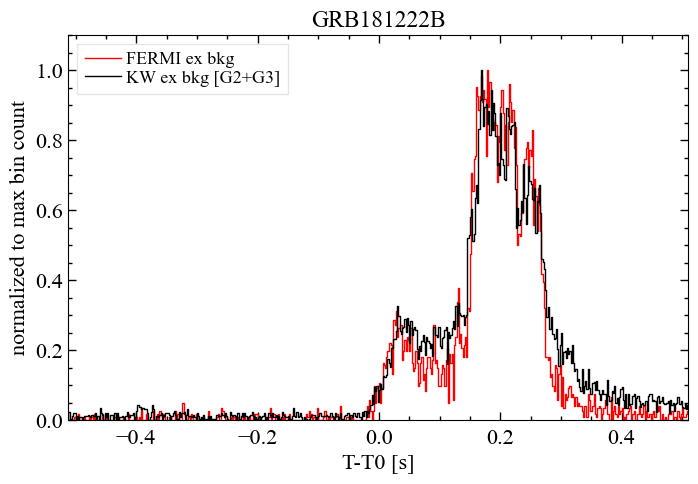

In [135]:
plt.step(x=bins[:-1],y=fermi_counts/max(fermi_counts),c='r',where='pre',label='FERMI ex bkg')
plt.step(x=bins[:-1],y=(G1+G2)/max(G1+G2),c='black',where='pre',label='KW ex bkg [G2+G3]')
#plt.vlines(x=[0.512,0.768],ymin=0,ymax=1.1,color='green',label='sp6 interval')
plt.ylim(bottom=0.0)
plt.legend()
plt.title('GRB181222B')
plt.xlabel('T-T0 [s]')
plt.ylabel('normalized to max bin count')
plt.show()

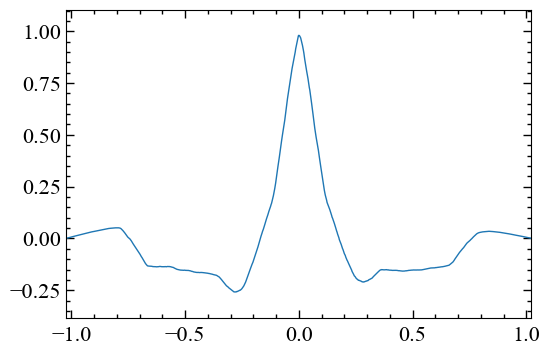

0.0


In [136]:
fermi_lc = LC(time=bins[:-1]+binsize/2,counts=fermi_counts,dt=binsize,skip_checks=True)
kw_lc = LC(time=bins[:-1]+binsize/2,counts=G1+G2,dt=binsize,skip_checks=True)

CC_fk = CC(kw_lc,fermi_lc,mode='full',norm='variance')
CC_fk.plot()
tlagg_fermi = CC_fk.time_shift 
print(tlagg_fermi)

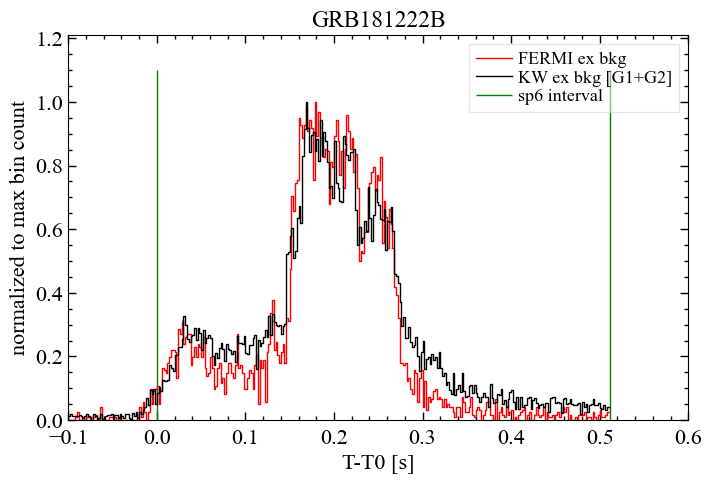

In [137]:
#fermi
tus_fermi = tte.data.time + CC_fk.time_shift
fermi_ix,fermi_jx = np.searchsorted(tus_fermi,bins[0]), np.searchsorted(tus_fermi,bins[-1])
tus_fermi = tus_fermi[fermi_ix:fermi_jx]
fermi_counts,fermi_edges = np.histogram(tus_fermi,bins=bins)
fermi_counts = np.maximum(fermi_counts - fermi_mean_bkg, 0)

plt.step(x=bins[:-1],y=fermi_counts/max(fermi_counts),c='r',where='pre',label='FERMI ex bkg')
plt.step(x=bins[:-1],y=(G1+G2)/max(G1+G2),c='black',where='pre',label='KW ex bkg [G1+G2]')
plt.vlines(x=[0.00,0.512],ymin=0,ymax=1.1,color='green',label='sp6 interval')
plt.ylim(bottom=0.0)
plt.xlim(left=-0.1,right=0.6)
plt.legend()
plt.title('GRB181222B')
plt.xlabel('T-T0 [s]')
plt.ylabel('normalized to max bin count')
plt.show()

## KW / ASIM cc

In [71]:
tof_kw_asim = 2.8716 # reached ISS first
T0_asim_approx = KW_T0 + timedelta(seconds=tof_kw_asim)
tlagg_approx_asim = (T0_asim-T0_asim_approx).total_seconds()
print(T0_asim)
print(T0_asim_approx)
print(f'asim tlagg estimation: {tlagg_approx_asim} s. apply to tus_asim')

2018-12-22 20:11:36.576000
2018-12-22 20:11:37.434600
asim tlagg estimation: -0.8586 s. apply to tus_asim


In [138]:
tlagg_approx_asim = -0.44

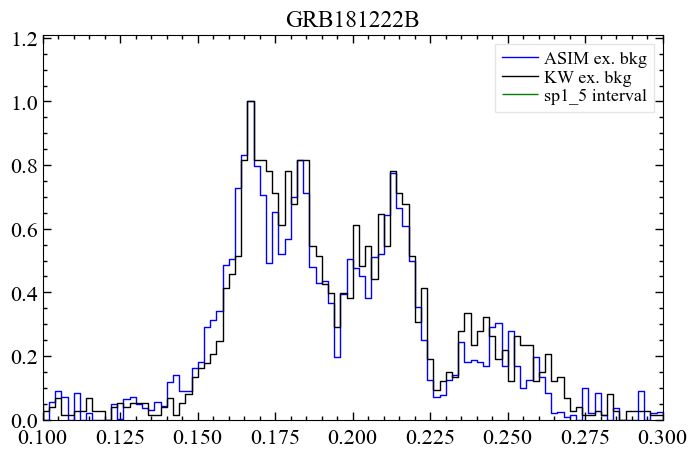

In [139]:
tus_asim = tus_asim_burst + tlagg_approx_asim

asim_counts, asim_edges = np.histogram(tus_asim, bins=bins)
asim_jx = np.searchsorted(asim_edges, -0.1)
asim_counts = np.maximum(asim_counts - np.mean(asim_counts[:asim_jx]), 0)

plt.step(x=bins[:-1], y=asim_counts/max(asim_counts), where='pre', label='ASIM ex. bkg',c='blue')
plt.step(x=bins[:-1],y=G3/max(G3),where='pre',label='KW ex. bkg',c='black')
plt.vlines(x=[0.0,0.512],ymin=0,ymax=1.1,label='sp1_5 interval',color='g')
plt.xlim(left=0.1, right=0.3)
plt.ylim(bottom=0.0)
plt.title("GRB181222B")
plt.legend()
plt.show() #evident that the asim lc must be shifted by ~ -0.6s

In [140]:
asim_lc = LC(time=asim_edges[:-1]+binsize/2,counts=asim_counts,skip_checks=True)
kw_lc = LC(time=bins[:-1]+binsize/2,counts=G3,skip_checks=True)
np.all(asim_lc.bin_lo == kw_lc.bin_lo)

True

tlagg_asim: 0.0


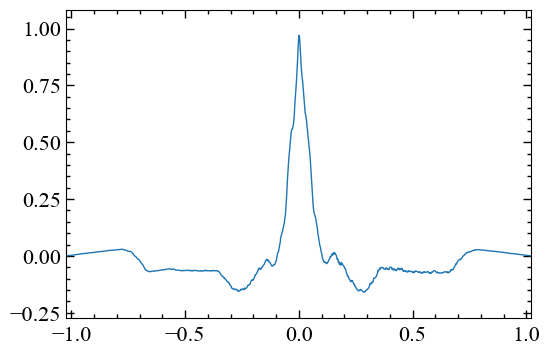

In [141]:
CC_kw_asim = CC(kw_lc,asim_lc,mode='full',norm='variance')
tlagg_asim = CC_kw_asim.time_shift
print(f'tlagg_asim: {tlagg_asim}')
CC_kw_asim.plot()
plt.show()

In [142]:
tlagg_asim = -0.44

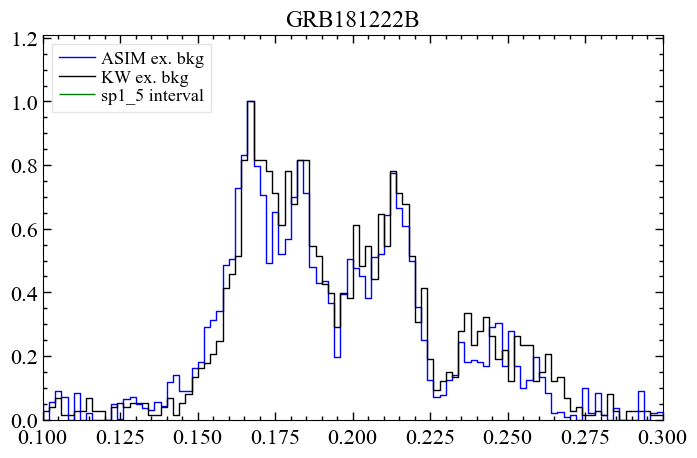

In [143]:
tus_asim_shifted = df_asim_burst['tus'].to_numpy() + tlagg_asim

asim_counts, asim_edges = np.histogram(tus_asim_shifted, bins=bins)
asim_jx = np.searchsorted(asim_edges, -0.1)
asim_counts = np.maximum(asim_counts - np.mean(asim_counts[:asim_jx]), 0)

plt.step(x=bins[:-1], y=asim_counts/max(asim_counts), where='pre', label='ASIM ex. bkg',c='blue')
plt.step(x=bins[:-1],y=G3/max(G3),where='pre',label='KW ex. bkg',c='black')
plt.vlines(x=[0.0,0.512],ymin=0,ymax=1.1,label='sp1_5 interval',color='g')
#plt.xlim(left=-0.512, right=0.6)
plt.xlim(left=0.1, right=0.3)
plt.ylim(bottom=0.0)
plt.title("GRB181222B")
plt.legend(loc='upper left')
plt.show() #evident that the asim lc must be shifted by ~ -0.6s

## ASIM / FERMI cc

In [134]:
tte = TTE.open(fn_tte)
tus_fermi = tte.data.time #+ tlagg_fermi
print(f'tlagg fermi: {tlagg_fermi}')
phaii = tte.to_phaii(bin_by_time,0.002,time_ref=0.0)
erange = (500,4e4)
lc_data = phaii.to_lightcurve(energy_range=erange)

tlagg fermi: 0.0008


In [135]:
tus_asim = df_asim_burst['tus'].to_numpy() + tlagg_approx_asim
i,j = np.searchsorted(tus_fermi,min(tus_asim)), np.searchsorted(tus_fermi,max(tus_asim))
tus_fermi_burst = tus_fermi[i:j]

In [136]:
fermi_lc = LC.make_lightcurve(toa=tus_fermi_burst,dt=0.002)
asim_lc = LC.make_lightcurve(toa=tus_asim,dt=0.002)

-0.008


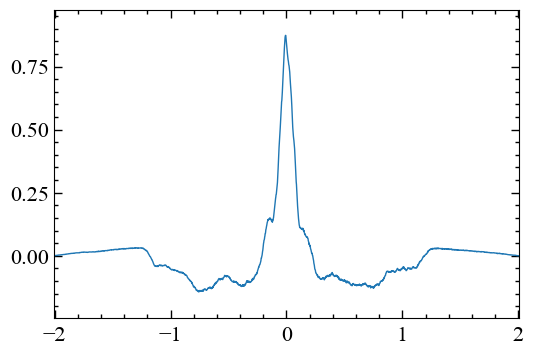

In [137]:
CC_fa = CC(fermi_lc,asim_lc,mode='full',norm='variance')
asim_shift_lc = asim_lc.shift(CC_fa.time_shift)
print(CC_fa.time_shift)
CC_fa.plot()
plt.show()

In [139]:
print(CC_fa.time_shift+ tlagg_approx_asim)

-0.438


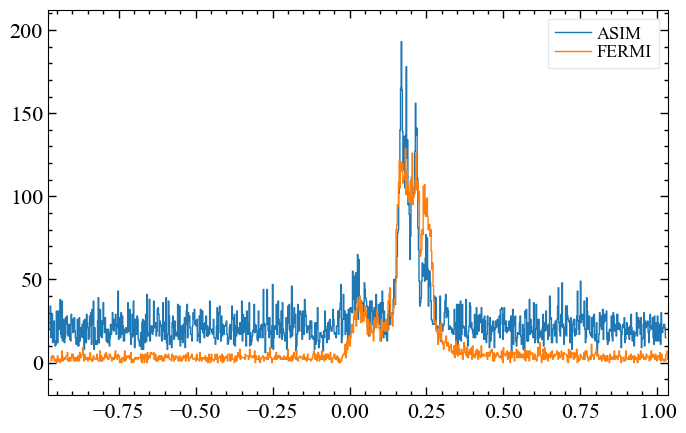

In [140]:
plt.step(x=asim_shift_lc.bin_lo, y=asim_shift_lc.counts,where='pre',label='ASIM')
plt.step(x=fermi_lc.bin_lo, y=fermi_lc.counts,where='pre',label='FERMI')
plt.legend()
plt.show()

# SUPERPLOT

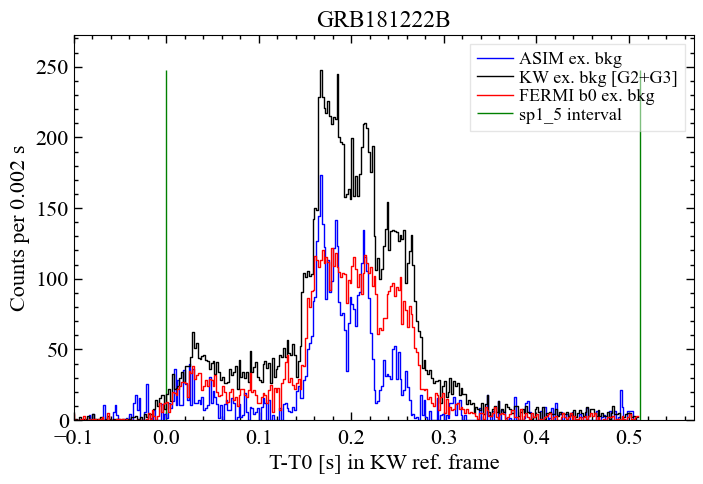

In [175]:
plt.step(x=bins[:-1], y=asim_counts, where='pre', label='ASIM ex. bkg',c='blue')
plt.step(x=bins[:-1],y=(G2+G3),where='pre',label='KW ex. bkg [G2+G3]',c='black')
plt.step(x=bins[:-1],y=fermi_counts,where='pre',label=f'FERMI {unit} ex. bkg',c='r')
plt.vlines(x=[0.0,0.512],ymin=0,ymax=max((G2+G3)),color='green',label='sp1_5 interval')
plt.ylim(bottom=0.0)
plt.xlim(left=-0.1,right=0.57)
plt.legend(loc='best')
plt.ylabel(f'Counts per {binsize} s')
plt.xlabel('T-T0 [s] in KW ref. frame')
plt.title('GRB181222B')
#plt.savefig('GRB181222B_superplot.png', dpi=300, bbox_inches='tight', format='png')
plt.show() #evident that the asim lc must be shifted by ~ -0.6s

# Extraction of FITS files

## ASIM extraction

In [105]:
tlagg_asim = -0.440
df_asim_burst['tus'] += tlagg_asim
T0_asim += timedelta(seconds=tlagg_asim)
print(T0_asim)
df_asim_burst.head()

2018-12-22 20:11:36.136000


,year,month,day,hour,minute,second,erg,dau,det,datetime,tus,adr,keV,st,dt,flag
18755,2018,12,22,20,11,36.035632,96,1,2,2018-12-22 20:11:36.035631639,-0.980368,2,1766.7429,2.511162,1.730883e+08,False
18756,2018,12,22,20,11,36.035894,1487,3,2,2018-12-22 20:11:36.035894333,-0.980106,8,29270.6895,19.000000,1.730887e+08,False
18757,2018,12,22,20,11,36.036055,70,2,1,2018-12-22 20:11:36.036054778,-0.979945,4,499.1194,1.982388,1.730883e+08,False
18758,2018,12,22,20,11,36.036161,1464,3,3,2018-12-22 20:11:36.036160694,-0.979839,9,27885.9238,19.000000,1.730883e+08,False
18759,2018,12,22,20,11,36.036168,38,4,3,2018-12-22 20:11:36.036168333,-0.979832,12,463.6063,0.636063,1.730894e+08,False


In [108]:
tus_asim = df_asim_burst['tus'].to_numpy() 
ix_asim, jx_asim = np.searchsorted(tus_asim,0), np.searchsorted(tus_asim,0.512)
df_burst_final = df_asim_burst.truncate(before=df_asim_burst.index[0]+ix_asim, after=df_asim_burst.index[0]+jx_asim)

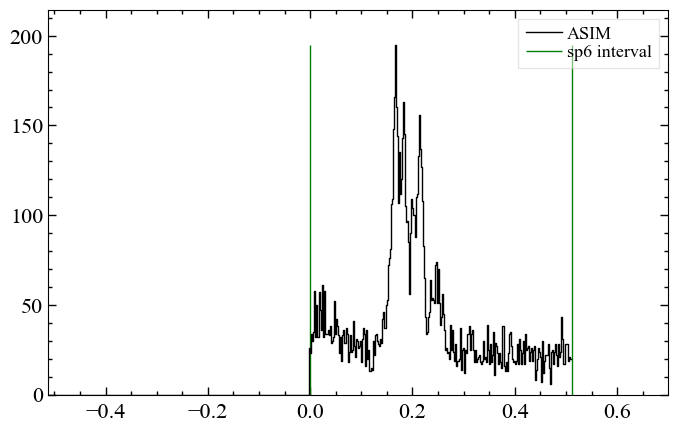

In [110]:
tus_asim = df_burst_final['tus'].to_numpy()

asim_counts, asim_edges = np.histogram(tus_asim, bins=bins)
plt.step(x=bins[:-1],y=asim_counts,where='pre',label='ASIM',c='black')
plt.vlines(x=[0.0,0.512],ymin=0,ymax=max(asim_counts),color='green',label='sp6 interval')
plt.ylim(bottom=0.0)
plt.xlim(left=-0.512, right=0.7)
plt.legend()
plt.show()

In [111]:
df_keV = keV_hist(df=df_burst_final,time_interval='max',keV_interval='max',convert_seconds=False)

Computing whole spectrum (10-1e5 keV)
n triggers in time interval  10532
n triggers are within bounds  10532
keV bins are set for HED
Energies binned!


In [113]:
bin_lo = df_keV['bins_keV'].to_numpy()[:-1]
bin_hi = df_keV['bins_keV'].to_numpy()[1:]
counts = df_keV['counts'].to_numpy()[1:]
err = df_keV['poisson_error_counts'].to_numpy()[1:]
len(bin_lo),len(bin_hi),len(counts),len(err)

(40, 40, 40, 40)

In [185]:
tus_burst = tus_asim[np.searchsorted(tus_asim,0.0):np.searchsorted(tus_asim,0.512)]
print('Exposure: ',np.round(tus_burst[-1]-tus_burst[0],3))
print(T0_asim)

Exposure:  0.512
2018-12-22 20:11:36.136000


### PHA

In [114]:
pha_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2018-12-22T20:11:36.136','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [0.00,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [0.512,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.512,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB181222B','Name of the observed object'], #<str> 
    'RA_OBJ': [311.7605,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [24.5163,'[deg] Dec of source'], #<float>
    'BACKFILE': ['HED_GRB181222B.bak','Background FITS file'], #<str> ('example.bak')
    'RESPFILE': ['HED_GRB181222B.rsp','Response FITS file'], #<str> ('example.rsp')
    'FILENAME': ['HED_GRB181222B.pha','PHA filename'] #<str>  ('example.pha')
}
#More keys can be declated. Set generatePHA(see_template=True) to view avalible keys,values & comments from the template HDR's

In [115]:
generatePHA(PHA_dict=pha_dict,bin_lo=bin_lo,bin_hi=bin_hi,stat_err=err,counts=counts)

### BAK
    - using background found in trigger file

In [34]:
#tlagg have already been applied
asim_jx = np.searchsorted(df_asim_burst['tus'].to_numpy(), -0.1)
df_bkg = df_asim_burst.truncate(after=df_asim_burst.index[0]+asim_jx)
df_bkg.tail()

,year,month,day,hour,minute,second,erg,dau,det,datetime,tus,adr,keV,st,dt,flag
28069,2018,12,22,20,11,36.914988,1965,1,3,2018-12-22 20:11:36.914987778,-0.101012,3,31807.6572,23.723063,1512.834,False
28070,2018,12,22,20,11,36.914988,1652,1,2,2018-12-22 20:11:36.914987806,-0.101012,2,28671.7817,19.937425,238.667,False
28071,2018,12,22,20,11,36.914988,90,1,1,2018-12-22 20:11:36.914987917,-0.101012,1,873.3881,2.493552,1512.889,False
28072,2018,12,22,20,11,36.915007,1710,1,1,2018-12-22 20:11:36.915006917,-0.100993,1,29272.3121,25.000000,19.000,False
28073,2018,12,22,20,11,36.915416,311,3,3,2018-12-22 20:11:36.915415806,-0.100584,9,6679.0830,9.000000,914.695,False


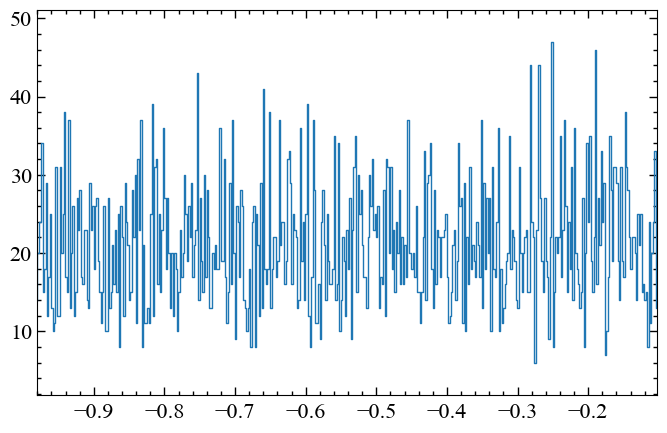

In [37]:
tus_asim_bkg = df_bkg['tus'].to_numpy()
bkg_counts,bkg_edges = np.histogram(tus_asim_bkg,bins=np.arange(min(tus_asim_bkg),max(tus_asim_bkg)+binsize,binsize))
plt.step(x=bkg_edges[:-1],y=bkg_counts)
plt.show()

In [38]:
df_kev_bkg = keV_hist(df_bkg,time_interval='max',keV_interval='max',convert_seconds=False)

Computing whole spectrum (10-1e5 keV)
n triggers in time interval  9318
n triggers are within bounds  9318
keV bins are set for HED
Energies binned!


In [40]:
print('Exposure bkg',np.round(tus_asim_bkg[-1]-tus_asim_bkg[0],4))
print('start',round(tus_asim_bkg[0],4))
print('end',round(tus_asim_bkg[-1],4))

Exposure bkg 0.8798
start -0.9804
end -0.1006


In [42]:
bak_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2018-12-22T20:11:36.136','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [-0.9804,'[s] Start time of background accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [-0.1006,'End time of background accumulation'], #<float> [s]
    'EXPOSURE': [0.8798,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB181222B','Name of the observed object'], #<str> 
    'RA_OBJ': [311.7605,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [24.5163,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB181222B.bak','Backgorund filename for fits file'] #<str>  ('example.bak')
}
#More keys can be declated. Set generatePHA(see_template=True) to view avalible keys,values & comments from the template HDR's

In [43]:
df_kev_bkg.head()

,bins_keV,counts,poisson_error_counts
0,10.00000,0,0.0
1,12.58925,0,0.0
2,15.84893,0,0.0
3,19.95262,0,0.0
4,25.11886,0,0.0


In [44]:
bak_counts = df_kev_bkg['counts'].to_numpy()[1:]
bak_err = df_kev_bkg['poisson_error_counts'].to_numpy()[1:]
bin_lo = df_kev_bkg['bins_keV'].to_numpy()[:-1]
bin_hi = df_kev_bkg['bins_keV'].to_numpy()[1:]

generateBAK(BAK_dict=bak_dict,bin_lo=bin_lo,bin_hi=bin_hi,bakCounts=bak_counts,stat_err=bak_err)

### RSP
    -generate new respone for each pha file, since exposure is varying (?)

In [188]:
rsp_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2018-12-22T20:11:36.136','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [0.000,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [0.512,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.512,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB181222B','Name of the observed object'], #<str> 
    'RA_OBJ': [311.7605,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [24.5163,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB181222B.rsp','RSP filename'] #<str>  ('example.pha')
}

In [189]:
theta,phi = 100.620, -49.010
drm_path = '/Home/siv30/wad005/master/HED_DRM/data'
drmfname = find_DRM_file(dir_path=drm_path,theta=theta,phi=phi)
print(drmfname)

HED_drm_mats_105.00_-45.00.txt


In [190]:
generateRSP(RSP_dict=rsp_dict,DRM_fname=drmfname,bin_lo=bin_lo,bin_hi=bin_hi,theta=theta,phi=phi)

## FERMI extraction
    -verified that TRIGTIME changed in new_tte.header

In [89]:
#need to create a new tte object, which is shifted by tlagg_kw_fermi
#%run /Home/siv30/wad005/master/GRB/xspec/FERMI/fermi_functions.ipynb
%run /Users/andreas/phys/master/GRB/xspec/FERMI/fermi_functions.ipynb

new_tte = createNewTTE(oldTTEObj=tte,tlagg=tlagg_fermi,binsize=binsize,unit=unit,obj='GRB181222B',grb_ra=grb_ra,grb_dec=grb_dec)
phaii = new_tte.to_phaii(bin_by_time, binsize) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

erange = (8, 1e3) #usually advised lower range. Standard passband
lc_data = phaii.to_lightcurve(energy_range=erange)

print('fitting background...')
bkgd_times = [(-200.0, -50.0), (150,250)] # where to extract the background
backfitter = BackgroundFitter.from_phaii(phaii, Polynomial, time_ranges=bkgd_times)
backfitter.fit(order=2) #increase order to 2 when you have a large interval 


All MAC paths are set!


<Figure size 800x500 with 0 Axes>


All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
FERMI functions loaded successfully!
tte shifted by -0.004
new TTE object created
fitting background...


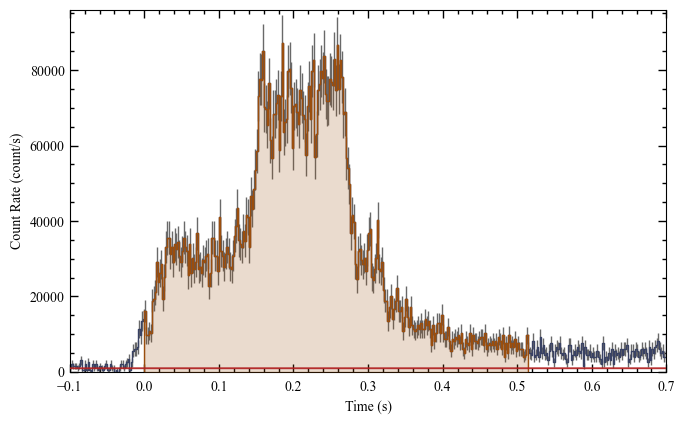

Normalised residuals: mean= 0.00121  std= 1.03
NormaltestResult(statistic=73121.81143897811, pvalue=0.0)


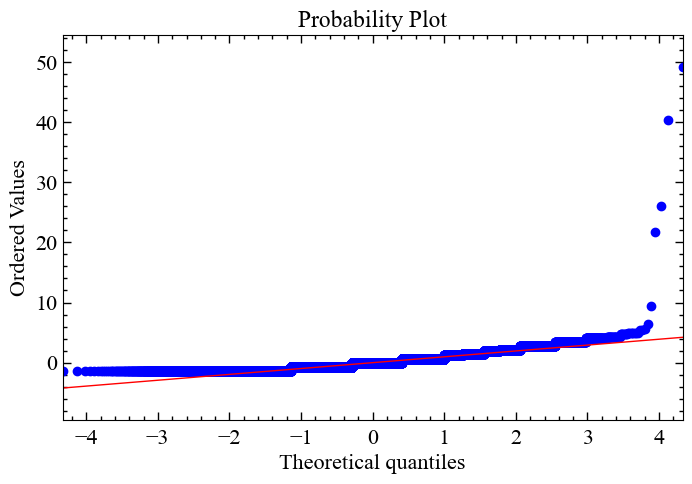

In [90]:
bkgd = backfitter.interpolate_bins(phaii.data.tstart, phaii.data.tstop)
lc_bkgd = bkgd.integrate_energy(*erange)
lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
src_time = (0.000,0.512)
view_range = (-0.1,0.7)
src_lc = phaii.to_lightcurve(time_range=src_time, energy_range=erange)
lcplot.xlim = view_range
lcplot.add_selection(src_lc)
plt.show()

# Define normalised residuals and test their compatibility with a standardized normal distribution
isel = np.where( ((lc_data.centroids>bkgd_times[0][0]) & (lc_data.centroids<bkgd_times[0][1])) | ((lc_data.centroids>bkgd_times[1][0]) & (lc_data.centroids<bkgd_times[1][1])) )[0]
isel_bkg = np.where( ((lc_bkgd.time_centroids>bkgd_times[0][0]) & (lc_bkgd.time_centroids<bkgd_times[0][1])) | ((lc_bkgd.time_centroids>bkgd_times[1][0]) & (lc_bkgd.time_centroids<bkgd_times[1][1])) )[0]
if np.all(isel == isel_bkg):
    norm_res = (lc_data.counts[isel]-lc_bkgd.counts[isel_bkg])/np.sqrt(lc_bkgd.counts[isel_bkg])
    print("Normalised residuals: mean= {:.3g}  std= {:.3g}".format(norm_res.mean(),norm_res.std()))
   # QQ plot to test normality
    import pylab 
    import scipy.stats as stats
    plt.cla()
    stats.probplot(norm_res, dist="norm",plot=pylab)
    from scipy.stats import normaltest
    print(normaltest(norm_res))
    plt.show()
#mu=0 std= 1 good, make sure the red line is not far frow the blue scatter plots

In [94]:
GRB_id = 'FERMI_GRB181222B'
src_time = (0.000,0.512)
pha = new_tte.to_pha(time_ranges=src_time)
# the background spectrum
bak = bkgd.to_bak(time_range=src_time)

# So now you have a PHA and BAK object which can be written as fully-formed FITS files using the `.write()` methods:
# ```python
fn_spectral = GRB_id + "_" + unit
bak.write('./', filename=fn_spectral+'.bak')
pha.write('./', filename=fn_spectral+'.pha', backfile=fn_spectral+'.bak')

# Read RSP function
rsp = RSP.open(fn_rsp)
# and interpolate response files to get DRMs at center of the source window
rsp_interp = rsp.interpolate(pha.tcent) #tcent central time of spectrum. interpolating the rsp at the time we specified

# Write response file
rsp_interp.write('./', filename=fn_spectral+'.rsp')

# It's advisable to set the RESPFILE keyword properly in the PHA file:
print("fparkey " + str(fn_spectral)+ ".rsp " + str(fn_spectral) + ".pha+2 RESPFILE")


fparkey FERMI_GRB181222B_n4.rsp FERMI_GRB181222B_n4.pha+2 RESPFILE
